In [1]:
import os
import warnings
from pathlib import Path

import cartopy
import matplotlib.animation
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML

In [2]:
casedir = Path("/glade/campaign/mmm/parc/mwong/ufs-mrw")

cases = sorted(casedir.glob("[12]?????????.F240.C768"))
fmt = "%Y%m%d%H"
itimes = [pd.to_datetime(c.name[:10], format=fmt) for c in cases]

workdir = Path(os.getenv("SCRATCH")) / "ks21_tmp"

print(f"found {len(itimes)} itimes in casedir {casedir}")

found 24 itimes in casedir /glade/campaign/mmm/parc/mwong/ufs-mrw


In [29]:
warnings.filterwarnings("ignore", category=UserWarning, module="cartopy")


def tissot(ax, df, **kwargs):
    ts = []
    for i, row in df.iterrows():
        t = ax.tissot(
            rad_km=row["Ro(km)"],
            lons=row["LON(E)"],
            lats=row["LAT(N)"],
            **kwargs,
        )
        ts.append(t)
    return ts


def label_id(ax, df, **kwargs):
    ts = []
    for i, row in df.iterrows():
        t = ax.text(
            x=row["LON(E)"],
            y=row["LAT(N)"],
            s=row["ID"],
            **kwargs,
        )
        ts.append(t)
    return ts


text_kw = dict(
    fontsize="xx-small",
    horizontalalignment="center",
    verticalalignment="center",
    transform=cartopy.crs.PlateCarree(),
)


def animate(i):
    ctime = ctimes[i]
    sfx = ".track"
    obs_path = ctime.strftime(
        "/glade/u/home/klupo/work_new/postdoc/kasugaEA21/version9/HGT_500mb/"
        f"gfs.0p25.%Y%m%d%H.f000{sfx}"
    )
    obs = pd.read_csv(
        obs_path,
        header=0,
        sep=r"\s+",
    )
    plt.cla()
    ax.coastlines()

    ts = tissot(ax, obs, alpha=0.2, color="k")
    ids = label_id(
        ax,
        obs,
        **text_kw,
    )

    fhr = (ctime - ctimes[0]) / pd.Timedelta(hours=1)
    if fhr == 0:
        sfx = ".dat"  # no .track file for f000, for some reason
    df = pd.read_csv(
        workdir
        / itime.strftime(fmt)
        / f"diag_TroughsCutoffs.{itime.strftime(fmt)}.f{fhr:03.0f}{sfx}",
        header=0,
        sep=r"\s+",
    )
    ax.set_title(f"{ctime} f{fhr:03.0f}")
    ts.extend(tissot(ax, df, alpha=0.4))
    if fhr > 0:
        ids = label_id(
            ax,
            df,
            **text_kw,
        )

    return ts

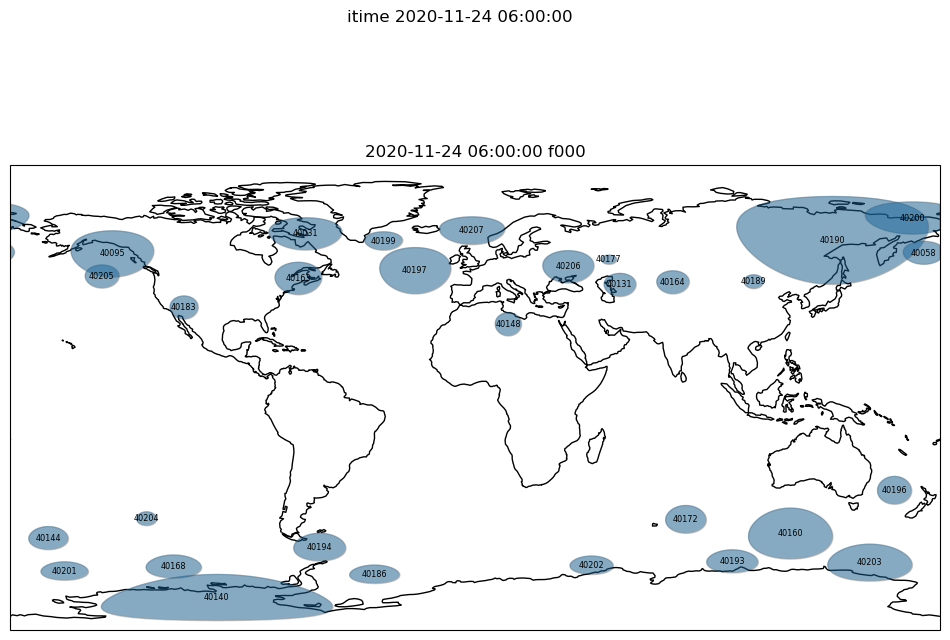

In [30]:
itime = itimes[12]
fig, ax = plt.subplots(
    figsize=(12, 8),
    subplot_kw={"projection": cartopy.crs.PlateCarree()},
)
fig.suptitle(f"itime {itime}")
leadtime = pd.Timedelta(hours=72)
ctimes = pd.date_range(start=itime, end=itime + leadtime, freq="6h")
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(ctimes))

HTML(ani.to_jshtml())